In [3]:
import os, sys
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from effmap.hst import HST

In [4]:
data = pd.read_csv('https://raw.githubusercontent.com/ivanokhotnikov/effmap_demo/master/data/test_data.csv')
data.dropna(subset=['Forward Speed', 'Reverse Speed', 'Volumetric at 1780RPM'], inplace=True)
speeds = data[['Forward Speed', 'Reverse Speed']].astype(float)
speeds = speeds.stack()
vol_eff = speeds / 1780 * 1e2

In [5]:
piston_max = 1.1653 * 25.4 * 1e-3
piston_min = 1.1650 * 25.4 * 1e-3
bore_max = 1.1677 * 25.4 * 1e-3
bore_min = 1.1671 * 25.4 * 1e-3
rad_clearance_max = (bore_max - piston_min) / 2
rad_clearance_min = (bore_min - piston_max) / 2

In [6]:
benchmark = HST(disp=196,swash=15,oil='SAE 30', oil_temp=60)
benchmark.compute_sizes(k1=.7155, k2=.9017, k3=.47, k4=.9348, k5=.9068)
eff_min = benchmark.compute_eff(speed_pump=1780, pressure_discharge=207, pressure_charge=14,h3=rad_clearance_max)
eff_max = benchmark.compute_eff(speed_pump=1780, pressure_discharge=207, pressure_charge=14,h3=rad_clearance_min)

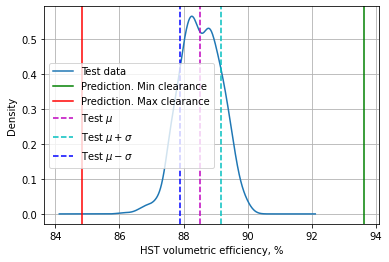

In [7]:
vol_eff.plot(kind='kde',grid=True,label='Test data')
plt.axvline(eff_max['hst']['volumetric'],linestyle='-',label='Prediction. Min clearance',color='g')
plt.axvline(eff_min['hst']['volumetric'],linestyle='-',label='Prediction. Max clearance',color='r')
plt.axvline(vol_eff.mean(),linestyle='--',label='Test $\mu$',color='m')
plt.axvline(vol_eff.mean()+vol_eff.std(),linestyle='--',label='Test $\mu + \sigma$',color='c')
plt.axvline(vol_eff.mean()-vol_eff.std(),linestyle='--',label='Test $\mu - \sigma$',color='b')
plt.xlabel('HST volumetric efficiency, %')
plt.legend()
plt.show()

In [8]:
df = data[['Serial No','Forward Speed', 'Reverse Speed']]
df[['Forward Speed', 'Reverse Speed']] = df[['Forward Speed', 'Reverse Speed']].astype(float) / 1780 * 1e2

<AxesSubplot:title={'center':'Forward'}, ylabel='Volumetric efficiency, %'>

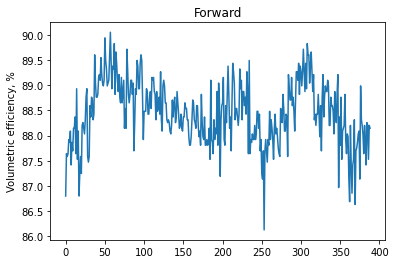

In [9]:
df_forward = df['Forward Speed'].reset_index(drop=True)
df_forward_np = np.array(df_forward)
df_forward.plot(title='Forward', ylabel='Volumetric efficiency, %')

<AxesSubplot:title={'center':'Reverse'}, ylabel='Volumetric efficiency, %'>

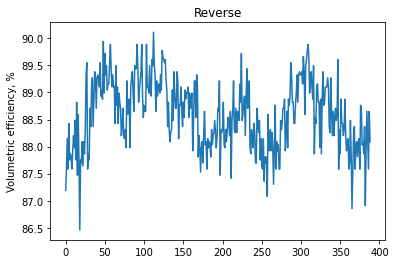

In [10]:
df_reverse = df['Reverse Speed'].reset_index(drop=True)
df_reverse_np = np.array(df_reverse)
df_reverse.plot(title='Reverse', ylabel='Volumetric efficiency, %')

In [45]:
date = df[['Serial No']].reset_index(drop=True).astype(str)
date = np.array([str(i)[:4] for i in date['Serial No']])

In [133]:
def moving_average(a, n=4):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
    # return np.average(a[-n:]) / n

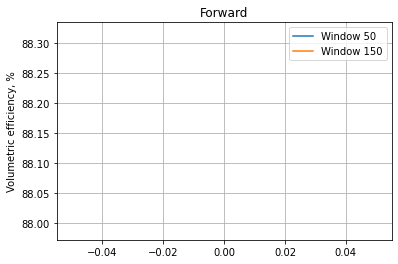

In [262]:
plt.plot(moving_average(df_forward_np, n=50), label='Window 50')
plt.plot(moving_average(df_forward_np, n=150), label='Window 150')
plt.title('Forward')
plt.ylabel('Volumetric efficiency, %')
plt.grid()
plt.legend()
plt.show()

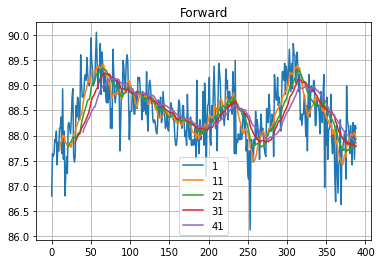

In [263]:
for i in range(1,51,10):
    df_forward.rolling(i).mean().plot(label=f'{i}', title='Forward', legend=True, grid=True)

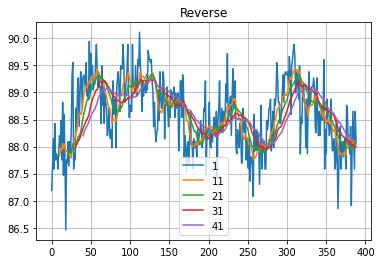

In [264]:
for i in range(1,51,10):
    df_reverse.rolling(i).mean().plot(label=f'{i}', title='Reverse', legend=True, grid=True)

In [265]:
n = 10
fig = go.Figure()
fig.add_scatter(
    mode='lines+markers',
    y=df_forward_np[n:],
    line=dict(
        width=.7,
        color='steelblue',
        shape='spline',
        smoothing=1.3
    ),
    connectgaps=True,
    name='Data',
)
fig.add_scatter(
    mode='lines+markers',
    y=moving_average(df_forward_np, n),
    line=dict(
        width=.7,
        color='indianred',
        shape='spline',
        smoothing=1.3
    ),
    connectgaps=True,
    name=f'Moving average, window {n}'
)
fig.update_layout(
    title='Forward',
    template='simple_white',
    yaxis_title='Volumetric efficiency, %',
    legend_orientation='h'
    ),
fig.show()

ValueError: 
    Invalid value of type 'numpy.float64' received for the 'y' property of scatter
        Received value: 87.95505617977528

    The 'y' property is an array that may be specified as a tuple,
    list, numpy array, or pandas Series

In [266]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataseries with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title(f"Moving average. Window size = {window}")
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.Series(index=series.index, data=series)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=5)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

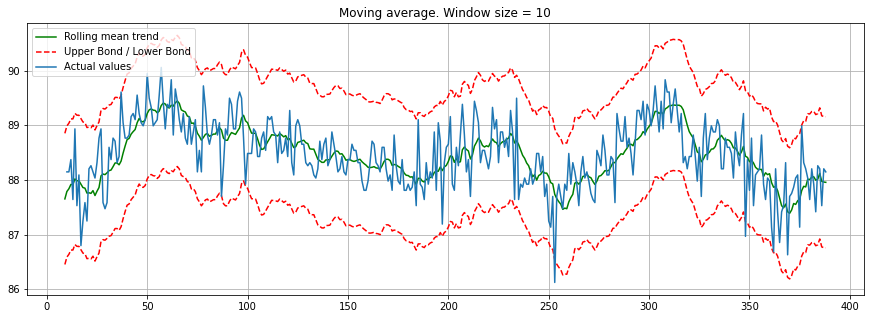

In [267]:
plotMovingAverage(df_forward, 10, plot_intervals=True, plot_anomalies=False)

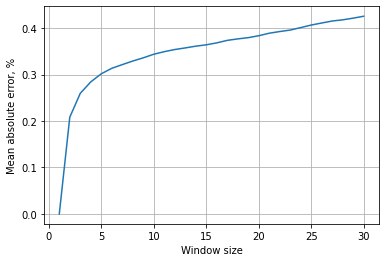

In [268]:
windows = range(1, 31)
# means_sk = [mean_absolute_error(df_forward.rolling(w).mean().dropna(), df_forward[w-1:]) for w in windows]
# plt.plot(windows, means_sk)
means = [np.mean(np.abs(df_forward.rolling(w).mean() - df_forward[w:])) for w in windows]
plt.plot(windows, means)
plt.xlabel('Window size')
plt.ylabel('Mean absolute error, %')
plt.grid()

In [269]:
def exponential_smoothing(series, alpha):
    """
        series - data series with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label=f"Alpha {alpha}")
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True)

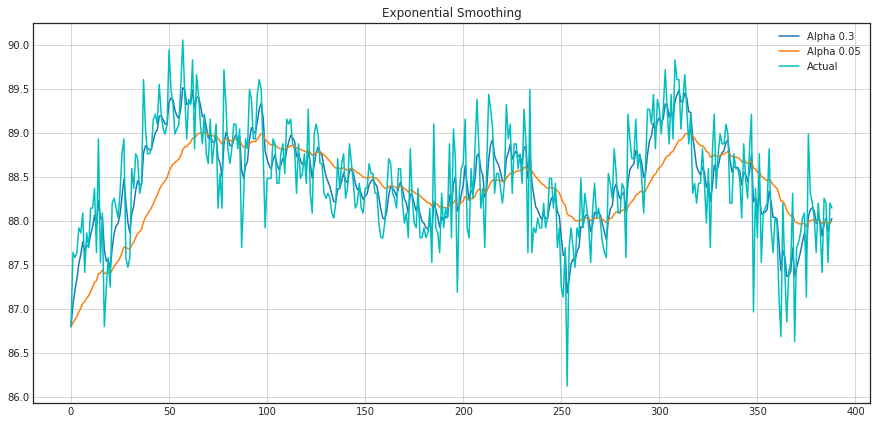

In [270]:
plotExponentialSmoothing(df_forward, [0.3, 0.05])